In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from keras.utils import to_categorical

In [42]:
df = pd.read_csv("train.csv")
df = np.array(df)
y = np.array(df[:, 0])
X = np.array(df[:, 1:])
X = X/255.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 13778)


In [43]:
#helper functions

def ReLU(X):
    return np.maximum(0, X)

def Softmax(V): 
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

def unison_shuffle(X, Y): 
    l = len(X) 
    idx_perm = np.random.permutation(l) 
    X_p = X[idx_perm] 
    Y_p = Y[idx_perm]
    return X_p, Y_p 

def ReLU_derivative(X):
    return X > 0

def onehot_encode(y):
    #convert vector y with size (n_samples x 1) into matrix Y with size (10 x n_samples)
    Y = np.zeros((y.max()+1, y.size))
    Y[y, np.arange(y.size)] = 1
    return Y

def onehot_encode1(Y):
    return to_categorical(Y, 10).T

def onehot_decode(Y):
    y = np.argmax(Y, axis=0)
    return y 

def get_accuracy(predictions, y):
    return np.sum(predictions == y) / len(y)

def CrossEntropyLoss(Y_hat, Y):
    e = 0.001
    n_samples = Y.shape[1]
    logY = np.log(Y_hat+e) 
    cost = -np.sum(np.multiply(Y,logY))
    return 1/n_samples*cost 

def CrossEntropyLoss1(Y_hat, Y):
    e = 0.0001
    n_samples = len(Y)
    logY = np.log(Y_hat+e) 
    cost = -np.sum(np.multiply(Y,logY))
    return 1/n_samples*cost 

def batch_normalize(A):
    e = 0.001
    ss = A.shape[0]
    M = 1/ss * np.sum(A, axis = 0)
    V = 1/(ss-1) * np.sum(np.square(A-M),axis = 0)

    nA = (A-M)/np.sqrt(V+e)
    return nA

In [44]:
def init_params():
    W0 = np.random.random((11, 784))
    b0 = np.random.random((11, 1))

    W1 = np.random.random((11, 11))
    b1 = np.random.random((11, 1))

    W2 = np.random.random((10, 11))
    b2 = np.random.random((10, 1))

    return W0, b0, W1, b1, W2, b2

def init_params1():
    W0 = np.random.rand(11, 784) - 0.5
    b0 = np.random.rand(11, 1) - 0.5
    W1 = np.random.rand(11, 11) - 0.5
    b1 = np.random.rand(11, 1) - 0.5
    W2 = np.random.rand(10, 11) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W0, b0, W1, b1, W2, b2

def forward_propagate(W0, b0, W1, b1, W2, b2, X):
    Z0 = np.dot(W0, X.T) + b0
    A0 = ReLU(Z0)

    Z1 = np.dot(W1, A0)  + b1 
    A1 = ReLU(Z1)

    Z2 = np.dot(W2, A1)  + b2 
    A2 = Softmax(Z2)

    return Z0, Z1, Z2, A0, A1, A2 

def forward_propagate1(W0, b0, W1, b1, W2, b2, X):

    Z0 = np.dot(W0, X.T) + b0
    A0 = ReLU(Z0)
    
    A0 = batch_normalize(A0)
    Z1 = np.dot(W1, A0)  + b1 
    A1 = ReLU(Z1)
    
    A1 = batch_normalize(A1)
    Z2 = np.dot(W2, A1)  + b2 
    A2 = Softmax(Z2)

    return Z0, Z1, Z2, A0, A1, A2 




def backward_propagate(Z0, A0, W0, Z1, A1, W1, Z2, A2, W2, X, y):
    m = y.size
    Y = onehot_encode1(y)

    dZ2 = A2 - Y 
    dW2 = 1/m * np.dot(dZ2, A1.T) 
    db2 = 1/m * np.sum(dZ2, axis= 1, keepdims= 1)

    dZ1 = np.dot(W2.T, dZ2) * ReLU_derivative(Z1)
    dW1 = 1/m * np.dot(dZ1, A0.T) 
    db1 = 1/m * np.sum(dZ1, axis= 1, keepdims= 1)

    dZ0 = np.dot(W1.T, dZ1) * ReLU_derivative(Z0)
    dW0 = 1/m * np.dot(dZ0, X) 
    db0 = 1/m * np.sum(dZ0, axis= 1, keepdims= 1)

    return dW0, db0, dW1, db1, dW2, db2 
                       

In [45]:
def gradient_descent(X, y, learning_rate, iterations):
    W0, b0, W1, b1, W2, b2 = init_params1()

    for i in range(iterations+1):

        Z0, Z1, Z2, A0, A1, A2 = forward_propagate(W0, b0, W1, b1, W2, b2, X)

        dW0, db0, dW1, db1, dW2, db2 = backward_propagate(Z0, A0, W0, Z1, A1, W1, Z2, A2, W2, X, y)

        W0 -= learning_rate*dW0 
        b0 -= learning_rate*db0
        W1 -= learning_rate*dW1 
        b1 -= learning_rate*db1
        W2 -= learning_rate*dW2 
        b2 -= learning_rate*db2

        if (i % 10 == 0):
            print(f"Iteration: {i}")
            predictions = onehot_decode(A2)
            print(f"Accuracy: {get_accuracy(predictions, y)}")

    return W0, b0, W1, b1, W2, b2 


def adam(X, y, alpha, beta1, beta2, batch_size, epochs):

    W0, b0, W1, b1, W2, b2 = init_params1()
    epsilon = 0.00001
    batchs = X.shape[0] // batch_size

    v_w2 = np.zeros_like(W2)
    v_b2 = np.zeros_like(b2)
    v_w1 = np.zeros_like(W1)
    v_b1 = np.zeros_like(b1)
    v_w0 = np.zeros_like(W0)
    v_b0 = np.zeros_like(b0)

    E_w2 = np.zeros_like(W2)
    E_b2 = np.zeros_like(b2)
    E_w1 = np.zeros_like(W1)
    E_b1 = np.zeros_like(b1)
    E_w0 = np.zeros_like(W0)
    E_b0 = np.zeros_like(b0)

    epsilonb2 = np.zeros_like(b2) + epsilon
    epsilonW2 = np.zeros_like(W2) + epsilon
    epsilonW1 = np.zeros_like(W1) + epsilon
    epsilonb1 = np.zeros_like(b1) + epsilon
    epsilonW0 = np.zeros_like(W0) + epsilon
    epsilonb0 = np.zeros_like(b0) + epsilon

    
    for i in range (epochs+1):
        Xs, ys = unison_shuffle(X, y)
        
        for j in range(batchs):
            X_batch = Xs[batch_size*j: (j+1)*batch_size,  :]
            y_batch = ys[batch_size*j: (j+1)*batch_size    ]

            Z0, Z1, Z2, A0, A1, A2 = forward_propagate1(W0, b0, W1, b1, W2, b2, X_batch)

            dW0, db0, dW1, db1, dW2, db2 = backward_propagate(Z0, A0, W0, Z1, A1, W1, Z2, A2, W2, X_batch, y_batch)

            v_w2 = beta1*v_w2 - (1-beta1)*dW2 
            v_b2 = beta1*v_b2 - (1-beta1)*db2 
            v_w1 = beta1*v_w1 - (1-beta1)*dW1 
            v_b1 = beta1*v_b1 - (1-beta1)*db1 
            v_w0 = beta1*v_w0 - (1-beta1)*dW0 
            v_b0 = beta1*v_b0 - (1-beta1)*db0 

            E_w2 = beta2*E_w2 + (1-beta2)*dW2*dW2 
            E_b2 = beta2*E_b2 + (1-beta2)*db2*db2 
            E_w1 = beta2*E_w1 + (1-beta2)*dW1*dW1 
            E_b1 = beta2*E_b1 + (1-beta2)*db1*db1 
            E_w0 = beta2*E_w0 + (1-beta2)*dW0*dW0 
            E_b0 = beta2*E_b0 + (1-beta2)*db0*db0 

            W2 += (alpha/np.sqrt(E_w2 + epsilonW2))*v_w2 
            b2 += (alpha/np.sqrt(E_b2 + epsilonb2))*v_b2 
            W1 += (alpha/np.sqrt(E_w1 + epsilonW1))*v_w1 
            b1 += (alpha/np.sqrt(E_b1 + epsilonb1))*v_b1 
            W0 += (alpha/np.sqrt(E_w0 + epsilonW0))*v_w0 
            b0 += (alpha/np.sqrt(E_b0 + epsilonb0))*v_b0 

        if (i % 10 == 0):
            print(f"Epoch: {i}")
            _, _, _, _, _, A2 = forward_propagate1(W0, b0, W1, b1, W2, b2, Xs)
            predictions = onehot_decode(A2)
            print(f"Accuracy: {np.round(get_accuracy(predictions, ys), 4)}")
            print(f"Loss: {np.round(CrossEntropyLoss(onehot_encode(predictions), onehot_encode(ys)), 4)}")
            print("--------------------------------------------------")
    
    return W0, b0, W1, b1, W2, b2




In [46]:
alpha = 0.01
epochs = 100
batch_size = 128
beta1 = 0.9 #momentum
beta2 = 0.9 #norm


W0a, b0a, W1a, b1a, W2a, b2a = adam(X_train, y_train, alpha, beta1, beta2, batch_size , epochs)

Epoch: 0
Accuracy: 0.8705
Loss: 0.8938
--------------------------------------------------
Epoch: 10
Accuracy: 0.9471
Loss: 0.3646
--------------------------------------------------
Epoch: 20
Accuracy: 0.9574
Loss: 0.2934
--------------------------------------------------
Epoch: 30
Accuracy: 0.961
Loss: 0.2682
--------------------------------------------------
Epoch: 40
Accuracy: 0.9608
Loss: 0.2698
--------------------------------------------------
Epoch: 50
Accuracy: 0.9656
Loss: 0.2369
--------------------------------------------------
Epoch: 60
Accuracy: 0.9665
Loss: 0.2303
--------------------------------------------------
Epoch: 70
Accuracy: 0.9682
Loss: 0.219
--------------------------------------------------
Epoch: 80
Accuracy: 0.9677
Loss: 0.2219
--------------------------------------------------
Epoch: 90
Accuracy: 0.9684
Loss: 0.2174
--------------------------------------------------
Epoch: 100
Accuracy: 0.9702
Loss: 0.205
--------------------------------------------------


In [47]:
_, _, _, _, _, A2 = forward_propagate1(W0a, b0a, W1a, b1a, W2a, b2a, X_test)
predictions = onehot_decode(A2)
print(f"Accuracy: {np.round(get_accuracy(predictions, y_test), 4)}")

Accuracy: 0.9314


Prediction: [1]


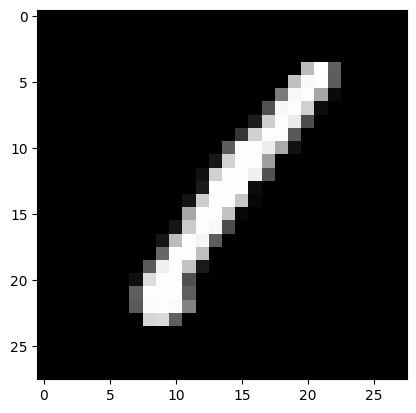

Prediction: [0]


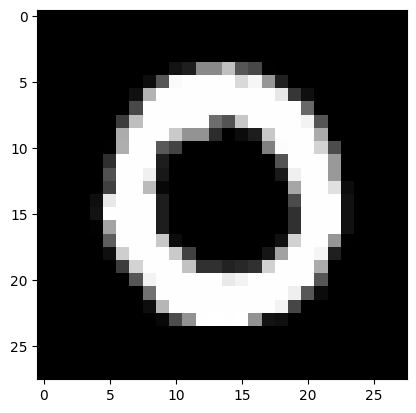

Prediction: [1]


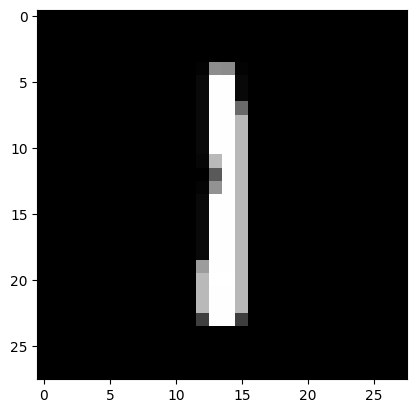

Prediction: [4]


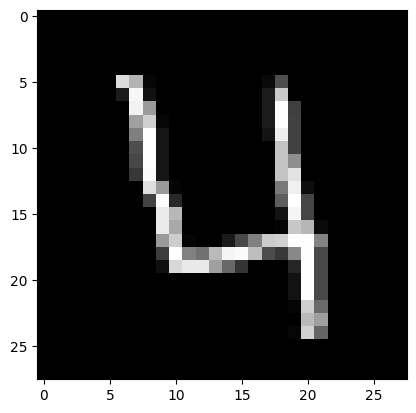

Prediction: [0]


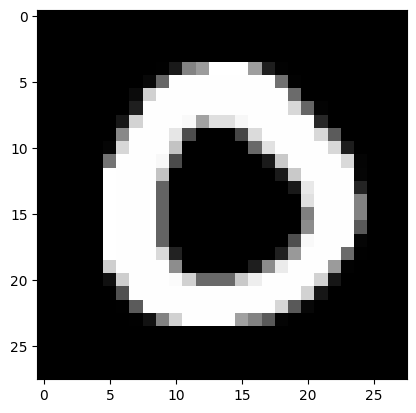

In [51]:
unseen = pd.read_csv("test.csv")
unseen = np.array(unseen)
def unseen_datas_prediction(sample_index, W0, b0, W1, b1, W2, b2, X):
    img = X[sample_index, :, None].reshape((28, 28))
    _, _, _, _, _, A2 = forward_propagate1(W0, b0, W1, b1, W2, b2, X[sample_index, :, None].T)
    prediction = onehot_decode(A2)
    print(f"Prediction: {prediction}")
    plt.gray()
    plt.imshow(img)
    plt.show()

def predict_unseen(index, W0, b0, W1, b1, W2, b2, X):
    for i in range(index, index+5):
        unseen_datas_prediction(i, W0, b0, W1, b1, W2, b2, X)

predict_unseen(0, W0a, b0a, W1a, b1a, W2a, b2a, X)

In [52]:
# np.save("W0.npy", W0a)
# np.save("W1.npy", W1a)
# np.save("W2.npy", W2a)
# np.save("b0.npy", b0a)
# np.save("b1.npy", b1a)
# np.save("b2.npy", b2a)